[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keisen/tf-keras-vis/blob/master/examples/visualize_conv_filters.ipynb)

When `tf-keras-vis` is not installed in your environment, please comment out and run the cell below.

In [1]:
# !pip install --upgrade tf-keras-vis tensorflow matplotlib

# Visualizing Conv filters using ActivationMaximization

### Load libraries

In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


### Load tf.keras.Model

In this notebook, we use VGG16 model, however if you want to use other tf.keras.Model, you can do so by modifying the section below.

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Visualizing a Conv filter

### Define a function to modify the model

You have to define a modifier to replace the model output to target layer's output that has filters you want to visualize, and replace the function to a linear activation function.

Here, we create and use `ExtractIntermediateLayer` and `ReplaceToLinear` instance.

In [4]:
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear

layer_name = 'block5_conv3' # The target layer that is the last layer of VGG16.

# This instance constructs new model whose output is replaced to `block5_conv3` layer's output.
extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=layer_name)
# This instance modify the model's last activation function to linear one.
replace2linear = ReplaceToLinear()

# Instead of using ExtractIntermediateLayer and ReplaceToLinear instance,
# you can also define the function from scratch as follows:
def model_modifier_function(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    target_layer.activation = tf.keras.activations.linear
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    return new_model

### Create ActivationMaximization Instnace

When `clone` argument is True(default), the `model` will be cloned, so the `model` instance will be NOT modified, however the process may take a while.

Here, because the ExtractIntermediateLayer instance will construct new model, setting `False`.

In [5]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 # Please note that `extract_intermediate_layer` has to come before `replace2linear`.
                                                 model_modifier=[extract_intermediate_layer, replace2linear],
                                                 clone=False)

### Define Score function

You MUST create `Score` instance or define `score function` that returns target scores. Here, it returns the 3rd filter value of `block5_conv3` layer. 

In [6]:
from tf_keras_vis.utils.scores import CategoricalScore

filter_number = 3
score = CategoricalScore(filter_number)

# Instead of using CategoricalScore object above,
# you can also define the function from scratch as follows:
def score_function(output):
    return output[..., filter_number]

### Visualize

ActivationMaximization will maximize the value computed by the score function. Here, we will visualize the 63rd convolutional filter.

200/200 [==============================] - 8s 35ms/step - Score: 861.2347 - TotalVariation2D: 23.2731 - Norm: 39.9557


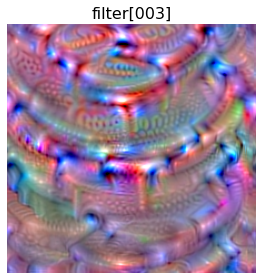

CPU times: user 8.09 s, sys: 422 ms, total: 8.52 s
Wall time: 8.49 s


In [7]:
%%time

from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D
 
# Generate maximized activation
activations = activation_maximization(score,
                                      callbacks=[Progress()])

## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(activations[0])
ax.set_title('filter[{:03d}]'.format(filter_number), fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

## Visualizing Conv filters

Then, let's visualize multiple convolutional filters!

### Define Score function

You MUST create `Score` instance or define `score function` that returns arbitrary filter values. Here, our socre function returns the values corresponding to 63rd, 132nd and 320th filters of the layer..

In [8]:
from tf_keras_vis.utils.scores import CategoricalScore

filter_numbers = [63, 132, 320]
scores = CategoricalScore(filter_numbers)

### Create SeedInput values

And then, you MUST create `seed_input` value. In default, when visualizing a specific filter, tf-keras-vis automatically generates `seed_input` to visualize a image. When visualizing multiple images, you MUST manually create `seed_input`.

In [9]:
# Define seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)

### Visualize

200/200 [==============================] - 14s 69ms/step - Score: 933.5200 - TotalVariation2D: 24.0820 - Norm: 39.8219


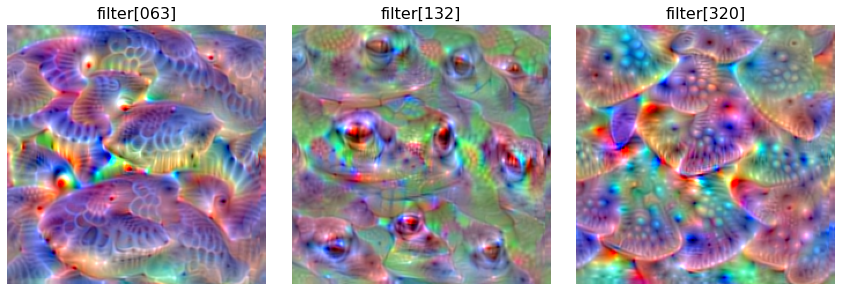

CPU times: user 14.2 s, sys: 325 ms, total: 14.5 s
Wall time: 14.7 s


In [10]:
%%time

from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D
 
# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])

## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, filter_number in enumerate(filter_numbers):
    ax[i].set_title('filter[{:03d}]'.format(filter_number), fontsize=16)
    ax[i].imshow(activations[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()